# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load data
train_label = pd.read_csv('data/train_labels.csv')
train_features = pd.read_csv('data/train_values.csv')
test_features = pd.read_csv('data/test_values.csv')
submission = pd.read_csv('data/SubmissionFormat.csv')

In [3]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Preprocessing Summary:

- Change `region_code` & `district_code` to 'object' type
- Change `construction_year` to 'object' type
- Convert `date_recorded` into year, month, & day features
- Dropped `num_private`, `recorded_by`, & `date_recorded` features

#### Encoding
- Fill missing values in categorical columns with 'unknown'
- Replaced instances from `funder`, `installer`, and `wpt_name` to 'Other' if less than 50
- OneHotEncoded categorical features (threshold: 150 or less)
- LabelEncoded remaining categorical features (likely none)

In [4]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')

# Try 'construction_year' as type 'object'
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Drop columns 'num_private', 'recorded_by', 'date_recorded' (and 'id' from train_df)
train_df = train_df.drop(columns=['num_private', 'recorded_by', 'date_recorded', 'id'])
test_features = test_features.drop(columns=['num_private', 'recorded_by', 'date_recorded'])

In [5]:
# Split `train_df` into train and test sets before additional encoding to prevent data leakage
X = train_df.drop(columns='status_group', axis=1)
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=604)

In [6]:
# Fill Categorical Columns with missing values in X_train, X_test, and test_features with 'unknown'
categorical_columns = X_train.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('unknown')
X_test[categorical_columns] = X_test[categorical_columns].fillna('unknown')
test_features[categorical_columns] = test_features[categorical_columns].fillna('unknown')

In [46]:
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name' if less than 200
# 200 appears to be the best threshold based on RF (vs. 100 or 300)

# Define the columns to be transformed
columns_to_transform = ['funder', 'installer', 'wpt_name',
                        'subvillage', 'scheme_name', 'ward'] # Try reducing features

# Function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, columns, threshold=200):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'Other')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

In [47]:
# Threshold for OneHotEncoding
threshold = 150

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

In [48]:
# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [49]:
# Apply Label Encoding (if needed)
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # Convert to string
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(lambda s: 'unknown' if s not in le.classes_ else s)  # Convert to string
    le.classes_ = np.append(le.classes_, 'unknown')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))
X_test_encoded = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat([
    X_train_encoded.reset_index(drop=True),
    X_train[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)
], axis=1)

X_test_final = pd.concat([
    X_test_encoded.reset_index(drop=True),
    X_test[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)
], axis=1)

print(f"Number of features after encoding: {X_train_final.shape[1]}")

Number of features after encoding: 367


In [50]:
# Label Encode for test_features
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'unknown' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'unknown')
        test_features[col] = le.transform(test_features[col])
        
test_features_encoded = pd.DataFrame(test_features_ohe, columns=ohe.get_feature_names_out(onehot_features))

test_features_final = pd.concat([test_features_encoded.reset_index(drop=True),
                                 test_features[labelencode_features + X.select_dtypes(
                                     include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)

# Model Scoring

#### Version 1 f1-scores:
| Model | Func / Repair / Non-func | Acc / M-Avg / W-Avg | Comp Score |
|-------|----------------------------------|---------------------------------|------------------|
| RF    | .84/.41/.80                      | .80/.68/.80                     | 0.7919           |
| CB    | .85/.37/.80                      | .80/.67/.79                     | 0.8064           |
| LGBM  | .84/.33/.79                      | .80/.67/.79                     | 0.7884           |
| DT    | .74/.30/.70                      | .69/.58/.69                     | n/a              |

#### Version 2: LE; OHE (threshold 10)
| Model   | Accuracy | Precision (macro avg) | Recall (macro avg) | F1-Score (macro avg) | Comp Score |
|---------|----------|-----------------------|---------------------|----------------------|------------|
| RF | 0.8019 | 0.7260 | 0.6638 | 0.6856 | 0.7875 |
| CB | 0.7978 | 0.7477 | 0.6336 | 0.6604 | 0.7831 |
| DT | 0.7251 | 0.6161 | 0.6225 | 0.6191 | n/a    |
| LGBM | 0.7758 | 0.7684 | 0.5951 | 0.6253 | 0.7411 |

#### Version 3: LE, OHE (threshold 20), depth 10
| Model   | Accuracy | Precision (macro avg) | Recall (macro avg) | F1-Score (macro avg) | Comp Score |
|---------|----------|-----------------------|---------------------|----------------------|------------|
| RF | 0.7446 | 0.7459 | 0.5282 | 0.5346 | 0.7463 |
| CB | 0.7958 | 0.7400 | 0.6338 | 0.6611 | 0.7551 |
| DT | 0.7322 | 0.7189 | 0.5437 | 0.5653 | n/a |
| LGBM | 0.7772 | 0.7500 | 0.5978 | 0.6246 | 0.7616 |

#### Version 4: OHE (threshold 50), depth 25 (depth 10 for CB)
| Model   | Accuracy | Precision (macro avg) | Recall (macro avg) | F1-Score (macro avg) | Comp Score |
|---------|----------|-----------------------|---------------------|----------------------|------------|
RF | 0.7964 | 0.7622 | 0.6259 | 0.6561 | 0.8033 |
CB | 0.7976 | 0.7513 | 0.6377 | 0.6665 | 0.8026 | 
DT | 0.7559 | 0.6500 | 0.6239 | 0.6346 | n/a |
LGBM | 0.7820 | 0.7603 | 0.607 | 0.6359 | 0.7809 |

## CatBoost will have separate notebook
- Documentation states not to use OneHotEncoding with CatBoost as it will affect the model
- Use internal OHE option instead
- Will use separate notebook

# Random Forest Classifier

In [51]:
# RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [300], #[100, 300],  # Number of trees
    'max_depth': [50], #[10, 25, 50],  # Maximum depth of each tree
    'min_samples_split': [2], #[2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [2], #[1, 2, 4],  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt'], #['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [False], #[True, False],  # Whether bootstrap samples are used when building trees
    'criterion': ['gini'] #['gini', 'entropy']  # Function to measure the quality of a split
}

#{'bootstrap': False,
# 'criterion': 'gini',
# 'max_depth': 50,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 300}

In [52]:
%%time
# Perform GridSearchCV
rf_gscv = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)
rf_gscv.fit(X_train_final, y_train)

CPU times: user 44 s, sys: 1.04 s, total: 45 s
Wall time: 1min 24s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2], 'min_samples_split': [2],
                         'n_estimators': [300]},
             scoring='accuracy')

In [36]:
# Retrieve the best parameters from the GridSearchCV
best_params_rf = rf_gscv.best_params_
best_params_rf

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [53]:
rf_preds = rf_gscv.predict(X_test_final)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.78      0.92      0.84      9678
functional needs repair       0.63      0.24      0.35      1295
         non functional       0.85      0.74      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.76      0.63      0.66     17820
           weighted avg       0.80      0.80      0.79     17820



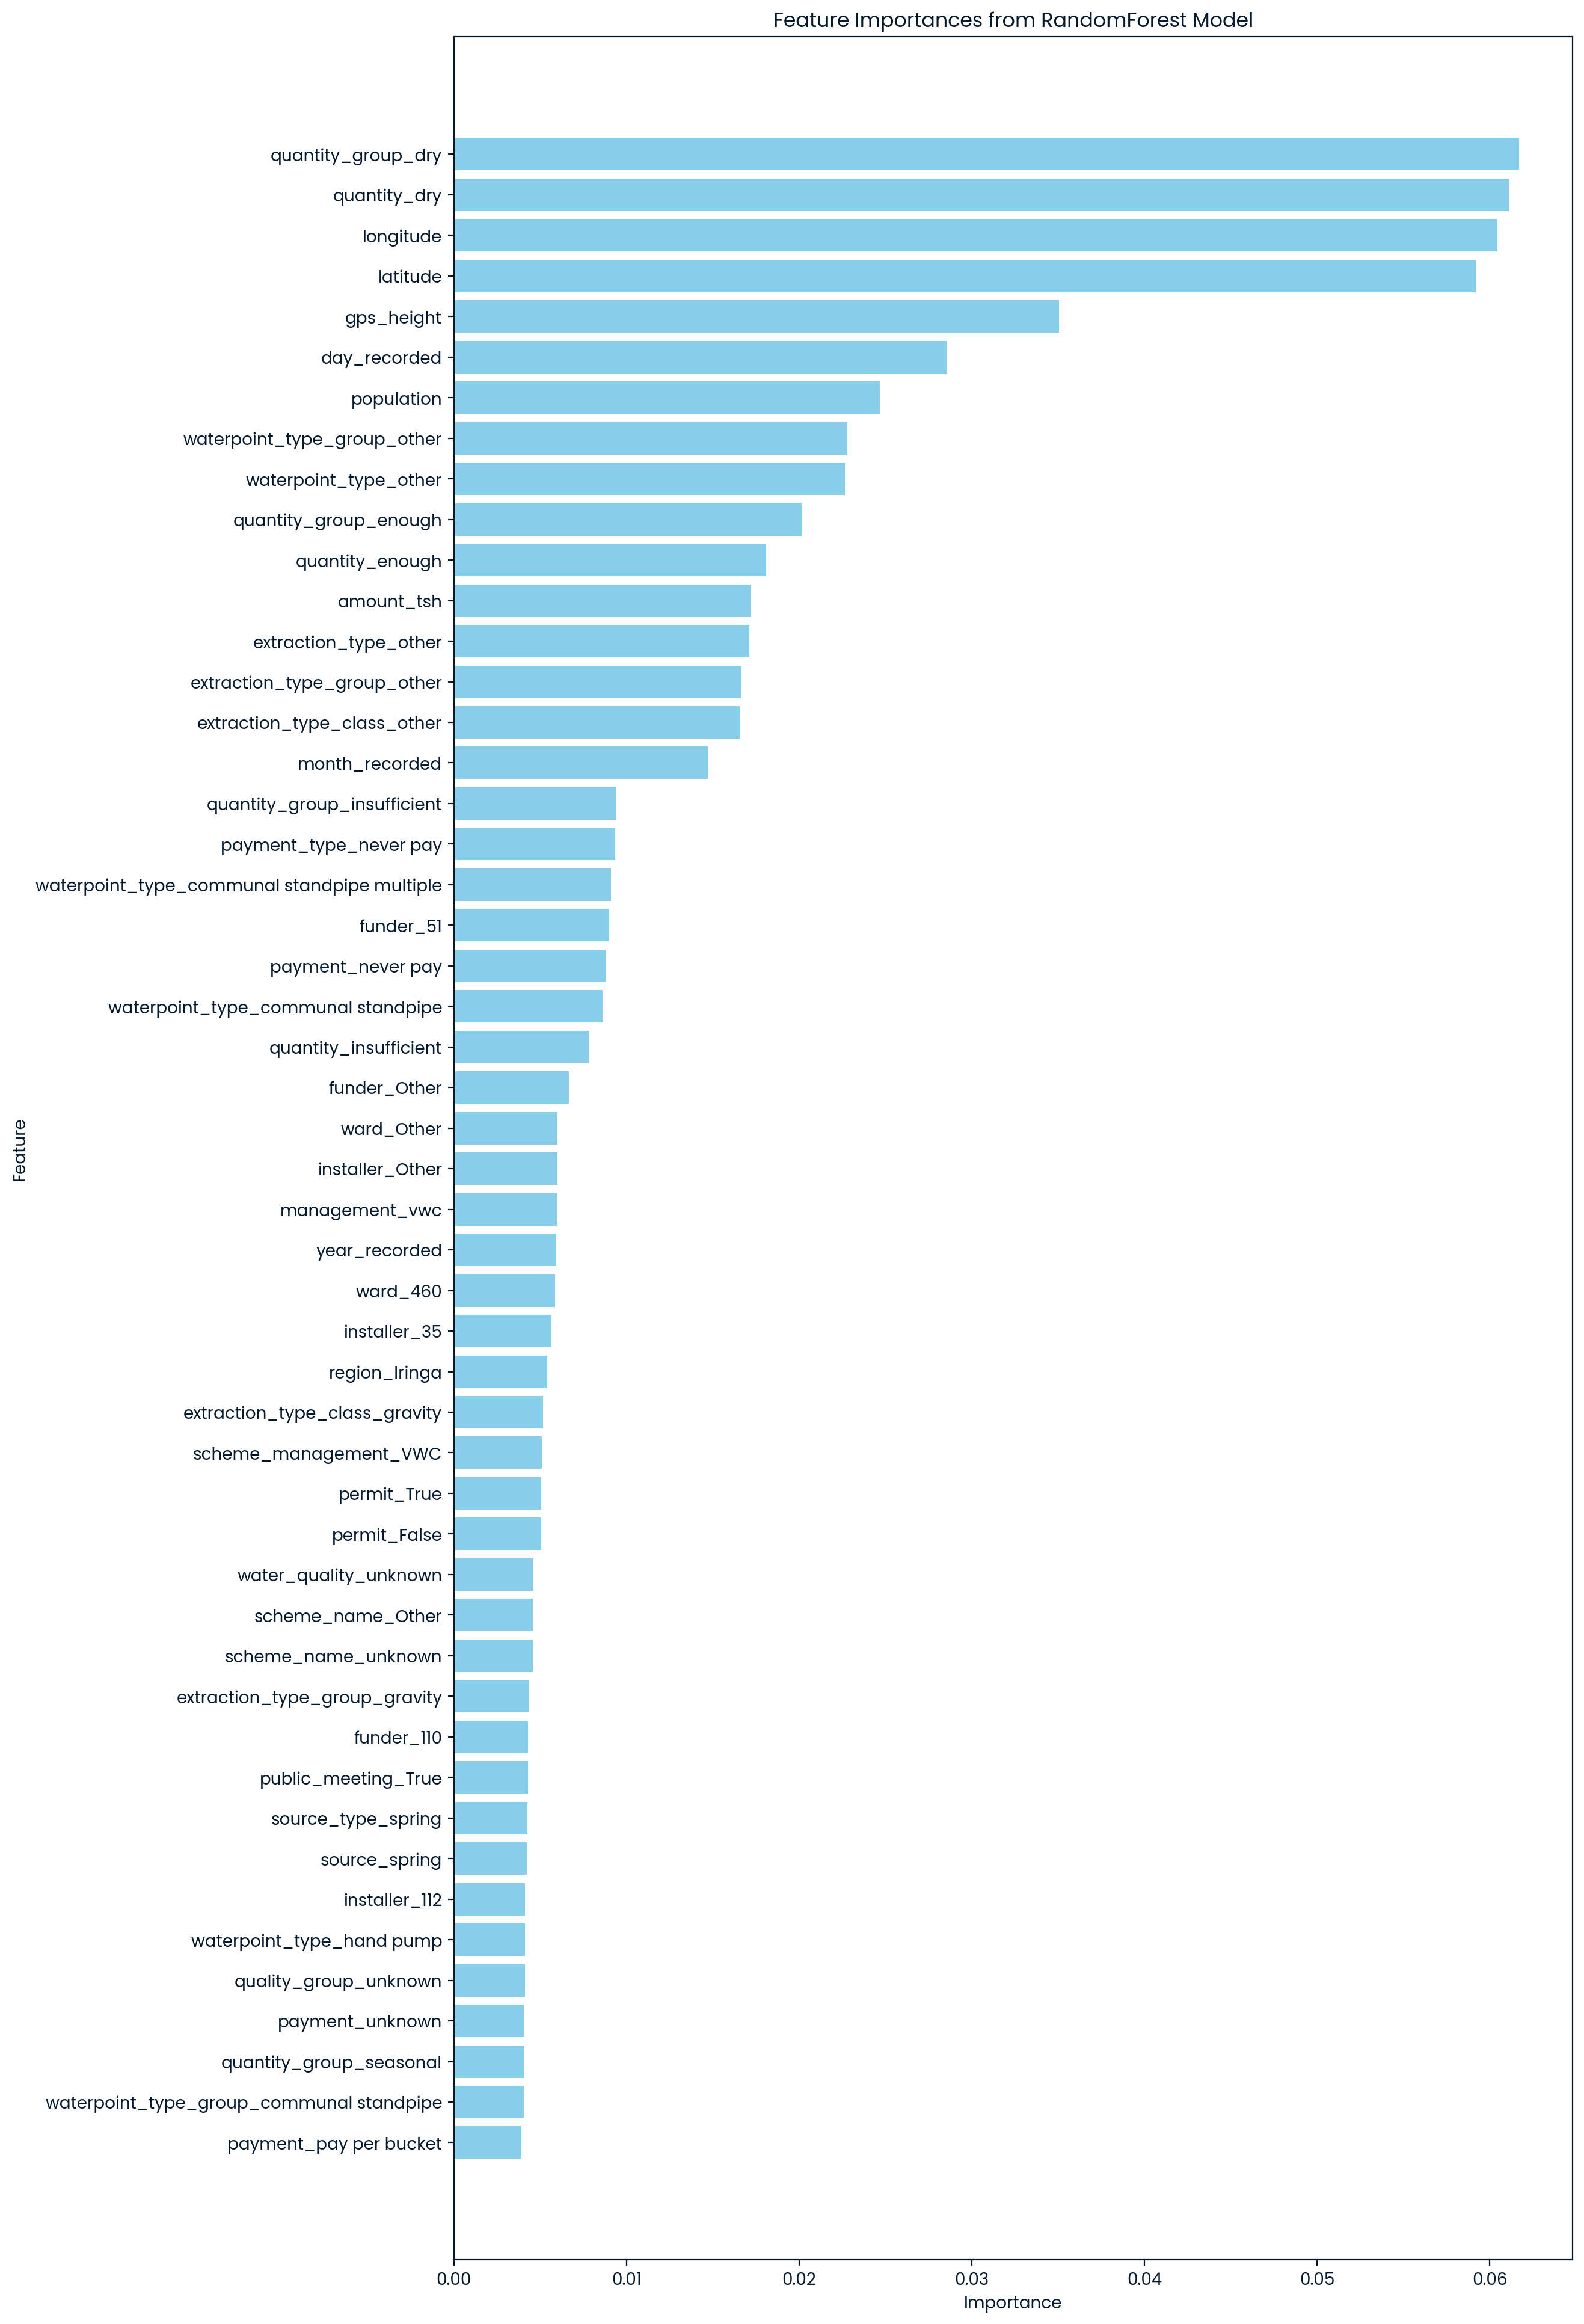

In [54]:
# Get the best estimator from the GridSearchCV object
best_rf_model = rf_gscv.best_estimator_

# Get feature importances from the best RandomForest model
rf_feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_feature_importances
})

# Sort the DataFrame by importance
rf_features_df = rf_features_df.sort_values(by='Importance', ascending=False).head(50)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(rf_features_df['Feature'], rf_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

In [55]:
# Predict using RandomForest model
rf_test_preds = rf_gscv.predict(test_features_final)

# Replace values in 'status_group' with rf_test_preds
submission['status_group'] = rf_test_preds

submission.to_csv('submission_rf5.csv', index=False)